# Image classification with Pytorch

In [6]:
import multiprocessing

In [7]:
multiprocessing.cpu_count()

6

In [8]:
!python --version

Python 3.10.11


In [9]:
!jupyter notebook --version

7.0.6


In [20]:
import torch
from torch import nn

In [19]:
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision import transforms

from torch.utils.data import DataLoader
from torch import optim

In [13]:
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline

In [15]:
torch.__version__

'2.1.2+cu121'

## Dataset: Flowers102

In [74]:
# labels https://github.com/wengsengh/Flowers-Image-Classifier/blob/master/cat_to_name.json
import json

with open('./data/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

Visualize sample

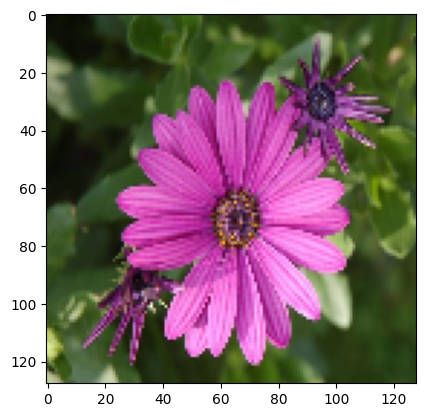

californian poppy


In [97]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),    
        transforms.Resize((128, 128)),
    ]
)

train_data = datasets.Flowers102(
    root='./data/train',
    split='train',
    download=False,
    transform=train_transforms
)

dataloader_train = DataLoader(
  train_data, shuffle=True, batch_size=1
)
image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0) 
# Display the image
plt.imshow(image)
plt.show()
print(cat_to_name[str(label.item())])

## Model

Model class has two  parts:

* feature extractor:
  * Conv2D - Applies a 2D convolution over an input signal composed of several input planes.
  * ELU - Applies the Exponential Linear Unit (ELU) function, element-wise.
  * MaxPool2d - Applies a 2D max pooling over an input signal composed of several input planes.
  * Flatten - Flattens a contiguous range of dims into a tensor.
* classifier:
  * Applies a linear transformation to the incoming data.

Convolutional layer:

* Convolutional layers preserve spatial information between their inputs and outputs.
* Adding zero-padding around the convolutional layer's input ensures that the pixels at the border receive as much attention as those located elsewhere in the feature map.
* Convolutional layers in general use fewer parameters than linear layers.

In [102]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1), # 32 output filters 32 X 64 X 64
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # Halve width and height 32 X 32 32
            nn.Conv2d(32,64,kernel_size=3,padding=1), # 64 output filters 64 X 32 X 32
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # Halve width and height 64 X 16 X 16
            nn.Flatten()
        )
        self.classifier = nn.Linear(64*16*16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x  

### Augmentation

In [103]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

train_data = datasets.Flowers102(
    root='./data/train',
    split='train',
    download=False,
    transform=train_transforms
)

dataloader_train = DataLoader(
  train_data, shuffle=True, batch_size=16
)

### Training

In [104]:
model = Net(num_classes=102)

In [105]:
model

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=16384, out_features=102, bias=True)
)

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    running_loss = 0.0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

### Evaluation

In [4]:
from torchmetrics import Precision, Recall

In [5]:
metric_precision = Precision(task='multiclass', num_classes=102, average='macro')
metric_recall = Precision(task='multiclass', num_classes=102, average='macro')

In this multi-class classification task it is important how you average the scores over classes. 

There four approaches:

* Not averaging, and analyzing the results per class;
* Micro-averaging, ignoring the classes and computing the metrics globally;
* Macro-averaging, computing metrics per class and averaging them;
* Weighted-averaging, just like macro but with the average weighted by class size.

In [107]:
# Define transforms
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

test_data = datasets.Flowers102(
    root='./data/test',
    split='test',
    download=False,
    transform=test_transforms
)

dataloader_test = DataLoader(
  test_data, shuffle=True, batch_size=16
)

In [108]:
model.eval()
with torch.no_grad():
    # iterate over test samples with no gradient
    for images, labels in dataloader_test:
        # get model output 
        outputs = model(images)
        # take most likely class
        _, predictions = torch.max(outputs, 1)
        # pass predicted class to metric
        metric_precision(predictions, labels)
        metric_recall(predictions, labels)
        
# compute metric
precision = metric_precision.compute()
recall = metric_recall.compute()

In [ ]:
print('precision: ', precision)
print('recall: ', recall)